<a href="https://colab.research.google.com/github/mcnewcp/kaggle-tabular-playground-series-sep21/blob/ajayi-begins/kaggle_sep2021_tab_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Playground | September 2021
This notebook produces a machine learning model to meet the rules and specifications of the [tabular playground](https://www.kaggle.com/c/tabular-playground-series-sep-2021/overview) September 2021 competition. 

From the overview page, the associated dataset was originally used to predict whether or not a customer filed an insurance claim. The data has been anonymized and generated through th [CTGAN](https://github.com/sdv-dev/CTGAN) deep learning synthetic data generation process.  

On this competition, Coy McNew and Evan Amway are collaborating with me.

_Format text wrapping in notebook_

In [ ]:
# Formatting Colab Output to Wrap Text
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Data Setup
To get started, we will import the required data-related files through the [Kaggle API](https://www.kaggle.com/docs/api). However, first, we will connect to Google Drive where the data will be housed after it has been extracted from Kaggle.

### Connect to to Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Kaggle"

### Point directory towards Kaggle directory in Google Drive
Connect to the .json file that contains the Kaggle API information, which is located in Google Drive


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/Kaggle

/content/gdrive/My Drive/Colab Notebooks/Kaggle


In [ ]:
# Install Kaggle API
!pip install -U kaggle

#### Acquire dataset for competition
Take a moment to confirm you are pointed toward the correct working directory, and then take a glance at the available files provided by the competition.

In [ ]:
# Confirm working directory
!pwd

/content/gdrive/My Drive/Colab Notebooks/Kaggle


In [ ]:
# Examine the files available for the tabular playground competition
!kaggle competitions files tabular-playground-series-sep-2021

name                  size  creationDate         
-------------------  -----  -------------------  
sample_solution.csv    6MB  2021-08-26 14:16:48  
train.csv            862MB  2021-08-26 14:16:48  
test.csv             444MB  2021-08-26 14:16:48  


Download .csv file from the competition website API. Upon visual inspection, you will see that the file is downloaded as a zipped .csv file (.csv.zip). Fortunately, pandas is capable of reading zipped .csv files.

In [ ]:
# Download the zipped .csv files from competition API to file path in Google Drive

## sample solution .csv
!kaggle competitions download tabular-playground-series-sep-2021 --file sample_solution.csv --path "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021"

## training set
!kaggle competitions download tabular-playground-series-sep-2021 --file train.csv --path "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021"

## test set
!kaggle competitions download tabular-playground-series-sep-2021 --file test.csv --path "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021"

sample_solution.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


### Import Necessary Preprocessing Modules


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

### Prepare training and test sets
To prepare the data sets for EDA, we will need to clean and process the datasets to allow for EDA to be helpful. 

First, let's take a look at the size of the training and test sets. 

In [ ]:
# Import training data from competition .csv
df_main_train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/train.csv.zip")

# Import test data from competition .csv
df_main_test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/test.csv.zip")


In [ ]:
# Take a look at the dimensions of the freshly imported dataframe.
print("There are {} rows and {} columns in the training set.".format(df_main_train.shape[0], df_main_train.shape[1]))
print("There are {} rows and {} columns in the test set.".format(df_main_test.shape[0], df_main_test.shape[1]))

There are 957919 rows and 120 columns in the training set.
There are 493474 rows and 119 columns in the test set.


Get information on the any differences between the columns of the test and training sets

In [ ]:
def listDiff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

coltrain = df_main_train.columns
coltest = df_main_test.columns

colDiff = listDiff(coltrain, coltest)
print("The following column(s) is(are) different betweeen the training and test: {}".format(colDiff))

The following column(s) is(are) different betweeen the training and test: ['claim']


According to this exercise, there is only one column that differs between the test and and trianing set. This column is called `claim`. The reason it is omitted form the test set is because it will be predicted and submitted to Kaggle for the competition as a probability. We will split the training set to test it before making predictions with the `test.csv` provided by the competition. 

Next, let's examine the training set more closely by learning about the datatypes of each column

In [ ]:
lst_train_dtypes = df_main_train.dtypes.value_counts()
print(lst_train_dtypes)

float64    118
int64        2
dtype: int64


The results show that almost all of the datatypes are floats except for two. These two exceptions are the `id` and the `claim` columns. Thus, working with mixed datatypes will not be an issue for this workbook. 

The next step will be to visualize these features to get a better understanding of how they will play in the model. Following thay step, the missing data will be analyzed. 


## Exploratory Data Analysis
Now with the data organized and arranged properly, we can explore the training set for trends and patterns. A specific effort with the EDA in this project is to select the best features for the model. Second, to engineer features that may enhance the potency of the modeling process.

EDA
- PCA (?)
- Feature selection
  * Chi-Squared test
  * [SelectKBest](https://www.datacamp.com/community/tutorials/feature-selection-python)
  * [Recursive Feature Elimination](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
  * Feature Importance: subsample a tiny amount of data and run a tree-based model and assess feature importantce

### Feature Selection
This data set has 119 features, a number that is difficult to glean simple patterns from. Similarly, fitting a model to all 119 features can lead to overfitting and poor performance when the model is deployed in the wild. 

- filter method
- wrapper method
[feature selection](https://towardsdatascience.com/feature-selection-techniques-1bfab5fe0784)

#### Filter Method | Feature Selection

In [ ]:
# Calculate the correlation between columns in the training set
corr_vals = df_main_train.corr()

Obtain a list of the features that have high correlations with the target variable. Work not shown demonstrates that these correlations, even the higher ones, are not great in magnitude $(<0.1)$. Nonetheless, this exercise provides information on how these features are correlated with the target variable. Greater correlation indicates the feature has a greater _linear_ influence on the magnitude on the target vice versa for the opposite.

In [ ]:
# Get the correlation values of the features with respect to the target
corr_claim= abs(corr_vals["claim"])
# Filter for relationships that excceed the given threshold
corr_claim_high = corr_claim[(corr_claim >= 0.01) & (corr_claim < 1.0) |
                             (corr_claim <= -0.01) & (corr_claim > -1.0)]
# Sort
corr_claim_high.sort_values(ascending=False)

f34    0.021505
f57    0.017977
f45    0.017692
f95    0.014771
f21    0.014342
f8     0.014311
f31    0.013903
f35    0.013777
f52    0.012356
f3     0.012016
f48    0.011988
f32    0.011715
f36    0.011640
f71    0.011572
f47    0.010279
f6     0.010200
Name: claim, dtype: float64

After collecting the features that demonstrated the greatest magnitude of correlation between themselves and the target variable, let's analyze the strength of the relationship between these high-_er_ correlated features.

<Figure size 3600x3000 with 0 Axes>

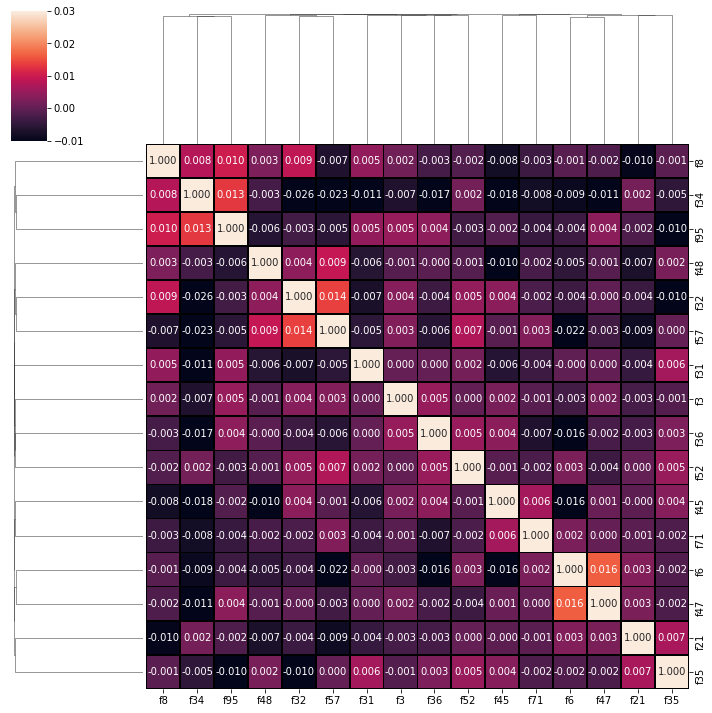

In [ ]:
# Get names of features with high correlation
corr_high_feats = corr_claim_high.index.tolist()
# Correlate important features with each other
corr_high_ = df_main_train[corr_high_feats].corr()

# Visualize
plt.figure(figsize=(12, 10), dpi=300, facecolor='w', edgecolor='k')
sns.clustermap(corr_high_, annot=True, fmt=".3f", linewidths=0.75, linecolor='k',
            vmin=-0.01, vmax=0.03)
plt.show()

This heatmap shows that there is little relationship between the features. At best they are related in trios with weak magnitudes of correlation. 

Overall, this exercise has not shown great correlation between the features and target, nor the between the _highly_ correlated feature. However, as mentioned in this [SO discussion](https://stackoverflow.com/questions/45917979/why-do-we-use-correlation-coefficient-for-feature-selection) under the selected answer, a lack of correlation does not portend poor data. Rather this merely means one cannot reduce some of the features upfront -- prior to the modeling. More importantly, **the lack of strongly correlated features may suggest that the relationships are in fact _non-linear_**.

However, we will conduct one more feature selection step to attmempt to reduce the dimensionality: Recursive Feature Elimination (RFE). -be sure to comment on the Darst et al. (2018) [paper](https://bmcgenomdata.biomedcentral.com/track/pdf/10.1186/s12863-018-0633-8.pdf)-. 

#### Wraper Method | Feature Selection
[RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) is used in this exercise to practice feature selection through a _sklearn_ wrapper. 

Specifically, a RFE continuously fits models to the data using a smaller and smaller set of features. This assists in the ability to glean what features are the most important.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import ExtraTreeClassifier as ETC
from sklearn.pipeline import Pipeline

# Randomly sample an equal amount of rows from the training set to reduce initial computation time
df_main_train_subsample = df_main_train.sample(frac=0.9, random_state=0)
df_main_train_subsample.dropna(inplace=True)

# Separate features from target
X = df_main_train_subsample.iloc[:,1:-1]
y = df_main_train_subsample.iloc[:,-1]

# Instantiate Model
extra_tree_clf = ETC(max_depth=8, min_samples_split=4,
                     max_features="sqrt", random_state=0)
# Instantiate RFE object
rfe_selector = RFE(estimator= extra_tree_clf,
                   step=0.03,
                   verbose=3)
# Create Pipeline
pipe = Pipeline(steps=[
                       ('selector',rfe_selector),
                       ('mdl', extra_tree_clf)
])
# Fit pipeline to data
fit_rslt = rfe_selector.fit(X,y)


Fitting estimator with 118 features.
Fitting estimator with 115 features.
Fitting estimator with 112 features.
Fitting estimator with 109 features.
Fitting estimator with 106 features.
Fitting estimator with 103 features.
Fitting estimator with 100 features.
Fitting estimator with 97 features.
Fitting estimator with 94 features.
Fitting estimator with 91 features.
Fitting estimator with 88 features.
Fitting estimator with 85 features.
Fitting estimator with 82 features.
Fitting estimator with 79 features.
Fitting estimator with 76 features.
Fitting estimator with 73 features.
Fitting estimator with 70 features.
Fitting estimator with 67 features.
Fitting estimator with 64 features.
Fitting estimator with 61 features.


In [ ]:
# Print Results
print("Num Features: %s" % (fit_rslt.n_features_))
print("Selected Features: %s" % (fit_rslt.support_))
print("Feature Ranking: %s" % (fit_rslt.ranking_))

Num Features: 59
Selected Features: [False False  True  True False False  True  True  True  True  True False
 False  True  True  True  True  True  True False  True  True False False
  True False False  True  True False  True False False  True  True False
 False False False False False False False  True  True False  True  True
 False False  True  True False False False  True False  True False  True
  True  True  True False False False  True False  True  True False  True
  True False  True False False False  True  True False False  True False
  True False  True  True False  True  True  True False  True  True False
  True  True False  True False  True False False  True False  True  True
 False False False False  True False  True False False False]
Feature Ranking: [19 17  1  1 14  8  1  1  1  1  1  2  3  1  1  1  1  1  1 16  1  1 19  6
  1  7  5  1  1 15  1 21 20  1  1 21 14 17 17 21  3 18 19  1  1  7  1  1
  9 16  1  1  7  8 12  1 11  1 11  1  1  1  1 12 13 12  1 13  1  1 18  1
  1 13  1

In [ ]:
from itertools import compress

# Retrieve the features selected from RFE
feats = X.columns.tolist()
feats_RFE_select = list(compress(feats, fit_rslt.support_))

# Compare RFE selected features to "highly" correlated features
colDiff = listDiff(feats_RFE_select, corr_high_feats)
print("The following column(s) is(are) different betweeen the training and test: {}".format(colDiff))
print("There are {} features that are in the 'highly' correlated group that are not in the RFE set of features.".format(len(colDiff)))

The following column(s) is(are) different betweeen the training and test: ['f56', 'f51', 'f98', 'f94', 'f108', 'f75', 'f70', 'f80', 'f63', 'f18', 'f11', 'f7', 'f15', 'f107', 'f29', 'f83', 'f115', 'f105', 'f60', 'f113', 'f67', 'f14', 'f10', 'f44', 'f72', 'f58', 'f90', 'f73', 'f79', 'f85', 'f62', 'f28', 'f100', 'f102', 'f17', 'f69', 'f87', 'f97', 'f4', 'f19', 'f92', 'f16', 'f88', 'f22', 'f25', 'f91', 'f61', 'f9', 'f6', 'f71', 'f36', 'f57', 'f32']
There are 53 features that are in the 'highly' correlated group that are not in the RFE set of features.


## Machine Learning
The modeling takes place in this section. First, the missing values are treated through a process of imputation and scaling. Next, the ML experiments are run. 

These experiments are separated by each subsection.

### Impute Missing Information
Using the median values per feature, fill in the missing rows. 

In [ ]:
from sklearn.impute import SimpleImputer

# Instantiate Imputer
imp_med = SimpleImputer(missing_values=np.nan, strategy="median", verbose=3)


In [ ]:
# Extract the subsection of training data that contains the RFE selected features
dmy = ["claim"]
feats_RFE_select_w_target = [*feats_RFE_select, *dmy]
df_relev = df_main_train[feats_RFE_select_w_target]

# Fit imputer to relevant data
imp_med = imp_med.fit(df_relev)

# Impute the fitted result
df_relev = imp_med.transform(df_relev)

### Normalize Information and Engineer Features

In addition to filing in the missing information with the median value, a standard [scaler function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from `scikit-learn` will provide a way to norm the data for better comparison across features.

_Borrowed the `CombinedAttributesAdder` from [Evan and Coy ](https://github.com/mcnewcp/kaggle-tabular-playground-series-sep21/blob/coy/evan-notebook-ohe-nan.ipynb)_. In short, the `CombinedAttributesAdder` aquires the sum of (normalized) values across the rows (excl. missing values) and number of missing values within each row. 

These methods will be used in a pipeline that will be used within the ML Experiments section (e.g., ml-2.3.1).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

# Instantiate Standard Scaler
scaler = StandardScaler()

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    #one hyperparameter per new feature
    def __init__(self, add_sum = True, add_num_nan = True): #no *args or **kargs
        self.add_sum = add_sum
        self.add_num_nan = add_num_nan
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X):
        #generate additional features
        if self.add_sum:
            std_scaler = StandardScaler()
            sum_col = X.copy()
            sum_col[np.isnan(sum_col)] = 0
            sum_col = std_scaler.fit_transform(sum_col)
            sum_col = sum_col.sum(axis=1)
            X = np.c_[X, sum_col]
        if self.add_num_nan:
            num_nan = np.isnan(X).sum(axis=1)
            X = np.c_[X, num_nan]
        return X

### Final data preparation - RFE
Prepare data for modeling by:
- Separating target from features
- splitting training and testing data (most useful for non-cross-validated methods)

In [ ]:
# Prepare data for modeling
## Separate target from features
X = df_relev[:,0:-1]
y = df_relev[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=0)

### Final data preparation - no RFE

### ML Experiments 

Versions:
- n.#.#: $n$ represents the type of features selected any major preprocessing steps
  * 1: RFE features and median imputing was used
  * 2: No RFE features were used, but scaling and imputing were used in addition to feature engineering
- #.n.#: Each $n$ represents a differnt model type:
  * 0: Linear Regression
  * 1: Random Forest Classifier
  * 2: SVC
  * 3: LightGradient Boosting
  * 4: XGBoost
  * 5: Naive Bayes Classifier
- #.#.n: Each $n$ highlights the type or set of parameters used for the ML algorithm
  * 0: Using default parameters
  * 1: Randomized Grid Search




#### ml-1.1.0 | RFE | Random Forest | Default Params

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC 

# Instantiate RF Classifier
rfc = RFC(verbose=3, random_state=0, n_jobs=-1)

rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.6min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=3,
                       warm_start=False)

Save model with `pickle` module. This is essential when executing long model runs on Google Colab and the model needs to be saved 

In [ ]:
import pickle

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
# Dump model into pickled file
with open(mdl_file_path+"mdl_1.1.0.pickle", "wb") as file:
  pickle.dump(rfc, file)

Load pickled model \
_The code below can be commented out, but it is a good idea to leave it to ensure that the model was picked properly_

In [ ]:
import pickle

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"

# Load Pickle Model
with open(mdl_file_path+"mdl_1.1.0.pickle", "rb") as file:
  rfc = pickle.load(file)

Evaluate the model by predicting the probability of claim being filed using the test data (i.e., test data that was split from the training set).

In [ ]:
# Make Predictions
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.6s finished


Examine the classification report for performance. First, 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
%matplotlib inline

# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.59      0.56    158165
         1.0       0.55      0.49      0.52    157949

    accuracy                           0.54    316114
   macro avg       0.54      0.54      0.54    316114
weighted avg       0.54      0.54      0.54    316114



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   16.4s finished


<Figure size 1800x1200 with 0 Axes>

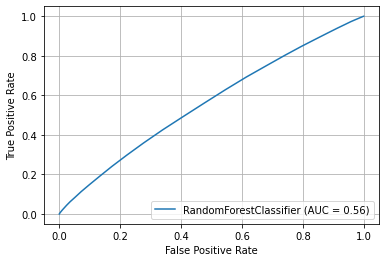

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import plot_roc_curve
import time

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"

# ROC curve
fig = plt.figure(dpi=300)
plot_roc_curve(rfc, X_test, y_test)
plt.grid(True)
plt.show()
roc_file_name = "roc_rfc_1.1.0_{}.png".format(time.strftime("%Y-%m-%d"))
plt.savefig(mdl_file_path+roc_file_name)

Calculate the probability that a claim has been filed against the hold out data set, or what Kaggle calls the `test.csv`.

In [ ]:
# Filter for the appropriate filters to match the input for rfc_1.1.0
df_hold_out_relev = df_main_test[feats_RFE_select]

# Use fitted (median) imputer
## Fit imputer to relevant data
imp_med = imp_med.fit(df_hold_out_relev)
## Impute the fitted result
df_hold_out_relev = imp_med.transform(df_hold_out_relev)

In [ ]:
# Use the trained model against the hold out data set
submission = rfc.predict_proba(df_hold_out_relev)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   25.7s finished


In [ ]:
# Get the probabilities that a claim has been made
submission_claim_pred = submission[:,1]

# Obtain the appropriate `id`s from the hold out data set and convert to numpy array
submission_ids = np.array(df_main_test.id)

# Horizontally concatenate the ids and submission probabilities
submission_for_csv = np.concatenate((submission_ids, submission_claim_pred),
                                    axis=1)

# Send to CSV
submission_for_csv = pd.DataFrame(submission_for_csv, columns=["id", "claim"])

array([0.54, 0.54, 0.52, 0.62, 0.45, 0.48, 0.54, 0.47, 0.54, 0.6 , 0.44,
       0.47, 0.45, 0.42, 0.54, 0.51])

In [ ]:
# Get the probabilities that a claim has been made
submission_claim_pred = submission[:,1].reshape(len(submission), 1)

# Obtain the appropriate `id`s from the hold out data set and convert to numpy array
submission_ids = np.array(df_main_test.id).reshape(len(df_main_test.id), 1)

# Horizontally concatenate the ids and submission probabilities
submission_for_csv = np.concatenate((submission_ids, submission_claim_pred),
                                    axis=1)


# Convert to dataframe and export to csv
## Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
mdl_fldr_path = "1.1.0"
## Convert
submission_for_csv = pd.DataFrame(submission_for_csv, columns=["id", "claim"])
submission_for_csv["id"] = submission_for_csv["id"].astype(np.int32)
## Get Dynamic Filename
submission_filename = "rfc_1.1.0_submission-{}.csv".format(time.strftime("%Y-%m-%d_%H%M%S"))
## Print to .csv
submission_for_csv.to_csv(mdl_file_path+submission_filename, index=False)

Submit to Kaggle competition\
_check paths to include model folder_

In [ ]:
submission_for_csv.dtypes

id         int32
claim    float64
dtype: object

Use the Kaggle API to make the submission

In [ ]:
!kaggle competitions submit -f "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/rfc_1.1.0_submission-2021-09-20_063433.csv" -m "submitting subpar model as first pass. used RFE to select features. corrected first submission so that the `id` column is a int32 datatype"  tabular-playground-series-sep-2021

100% 6.03M/6.03M [00:00<00:00, 17.2MB/s]
Successfully submitted to Tabular Playground Series - Sep 2021

#### ml-2.2.1 | No RFE | Support Vector Classifier (SVC) | RandomGridSearchCV

Instead of using the RFE feature selection processs to reduce the width of the dataset, this "no RFE" pathway will incorporate all features.

To prepare the data, we will implement a pipeline that will:
- create a new feature that sums the missing value across and another feature that sums the normalized values across each row
- imputes the missing data with the median value
- scales (normalizes) data within each column/feature

_Keep in mind, to use this subsection, be sure to execute cells within the "Normalize Information and Engineer Features" subsection_

##### Create a Pipeline | GridSearch Inside Pipeline

A [pipeline](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf) will connect preprocessing steps to the implementation of the machine learning model. 

As described above, imputation, normalization, and light feature engineering are incorporated into the pipeline. Additionally, a [Support Vector Classifier (SVC)]() will also be added to the pipeline. The parameters for the SVC will be randomly drawn and the model runs will be cross-valdidated with the [`RandomizedSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). 

SVC, a member of the Support Vector Machine (SVM) family, is a discriminative classifier that uses labeled training data and ouputs an optimal hyperplane to categorize new examples. In other words, the line(s) separating the labelled classes in the trained model are used to categorize incoming data.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer

# SVMClassifier
svc_clf = SVC(random_state=0, verbose=True)

# Design Scoring Function
f1_scorer = make_scorer(f1_score, average="binary")

# Parameter Grid
param_grid = {
    "kernel":["rbf", "linear"],
    "C":[int(x) for x in np.linspace(0.01, 100, num = 15)]
    }

# Create a pipeline to train a model with the preprocessing steps mentioned in "Normalization Information and Engineer Features" section
svc_rnd_grid = make_pipeline(CombinedAttributesAdder(),
                             imp_med,
                             scaler,
                             RandomizedSearchCV(estimator = svc_clf,
                                                param_distributions = param_grid,
                                                n_iter = 12,
                                                cv = 3,
                                                scoring = f1_scorer,
                                                random_state = 0,
                                                verbose=3)
)

# Corrected version of make_pipeline https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit
svc_rnd_grid = make_pipeline(
    CombinedAttributesAdder(),
    imp_med,
    scaler,
    svc_clf
)

###### Prepare the data for fitting

Since we will be running a cross-fold validation (cv), we will not split the training data into train and test. This is a little risky because we will not be able to evaluate the training data as well if we made the split; however, we can view the cv results to understand how well the fits for each partition are scored.

The features will include all of the variables except the `id` and the `claim`. Of course, the target will include just the `claim` as a series.

In [ ]:
# Prepare data for modeling
## Separate target from features (i.e. remove the "id" and the "claim" from the feature set)
X = df_main_train.iloc[:,1:-1]
## Isolate "claim" as the target variable
y = df_main_train.iloc[:,-1]

###### Fit the pipeline to the prepped data

In [ ]:
svc_rnd_grid.fit(X, y)

[LibSVM]

###### Pickle pipeline for later

Save the fitted pipeline to be used at a later date

In [ ]:
import pickle

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
# Dump model into pickled file
with open(mdl_file_path+"mdl_2.2.1-pipe.pickle", "wb") as file:
  pickle.dump(svc_rnd_grid, file)

###### Create submission | GridSearch in Pipeline

In order to submit to the competition, use the fitted pipeline to predict the unknown claims using the hold out feature set. This should create a two column `.csv` file that will be uploaded to the Kaggle competition.

In [ ]:
# Prepare data for modeling
## Separate target from features (i.e. remove the "id" and the "claim" from the feature set)
X_hold_out = df_main_test.iloc[:,1:]

In [ ]:
submission = svc_rnd_grid.predict_proba(X_hold_out)

In [ ]:
import time

# Get the probabilities that a claim has been made
submission_claim_pred = submission[:,1].reshape(len(submission), 1)

# Obtain the appropriate `id`s from the hold out data set and convert to numpy array
submission_ids = np.array(df_main_test.id).reshape(len(df_main_test.id), 1)

# Horizontally concatenate the ids and submission probabilities
submission_for_csv = np.concatenate((submission_ids, submission_claim_pred),
                                    axis=1)


# Convert to dataframe and export to csv
## Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
mdl_fldr_path = "2.2.1"
## Convert
submission_for_csv = pd.DataFrame(submission_for_csv, columns=["id", "claim"])
submission_for_csv["id"] = submission_for_csv["id"].astype(np.int32)
## Get Dynamic Filename
submission_filename = "svm_clf.2.2.1_submission-{}.csv".format(time.strftime("%Y-%m-%d_%H%M%S"))
## Print to .csv
submission_for_csv.to_csv(mdl_file_path+submission_filename, index=False)

###### Submit results | GridSearch in Pipeline

Submit results from hold out data prediction to the Kaggle competition through the API

In [ ]:
!kaggle competitions submit -f "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/light_gbm_clf.2.1.3_submission-2021-09-27_165748.csv" -m "submitting blindly since model will finish while at work. this is a lightgbm model using some fe and median imputer"  tabular-playground-series-sep-2021

100% 12.8M/12.8M [00:00<00:00, 25.9MB/s]
Successfully submitted to Tabular Playground Series - Sep 2021

In [ ]:
svc_rnd_grid.fit(X, y)

#### ml-2.3.1 | No RFE | LightGradient Boosting | RandomGridSearchCV
Instead of using the RFE feature selection processs to reduce the width of the dataset, this "no RFE" pathway will incorporate all features.

To prepare the data, we will implement a pipeline that will:
- create a new feature that sums the missing value across and another feature that sums the normalized values across each row
- imputes the missing data with the median value
- scales (normalizes) data within each column/feature

_Keep in mind, to use this subsection, be sure to execute cells within the "Normalize Information and Engineer Features" subsection_

In [ ]:
!pip install lightgbm

##### Create the Pipeline | GridSearch in Pipeline

A [pipeline](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf) will connect preprocessing steps to the implementation of the machine learning model. 

As described above, imputation, normalization, and light feature engineering are incorporated into the pipeline. Additionally, a [Light GBM Classifier](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf), which was recently developed by Mircrosoft, enhances the performance of a gradient boosting decision tree (GBDT). _-add more text here about LightGBM-_

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, make_scorer

# LightGBM Classifier
lightGB_clf = LGBMClassifier(random_state=0, 
                             silent=False, 
                             objective="binary")

# Design Scoring Function
f1_scorer = make_scorer(f1_score, average="binary")

# Parameter Grid
param_grid = {
    "boosting_type":["gbdt", "goss"],
    "num_leaves":[int(x) for x in np.linspace(10, 110, num = 11)],
    "max_depth":[int(x) for x in np.linspace(-1, 11, num = 5)],
    "learning_rate":[x for x in np.linspace(0.1, 0.5, num = 3)],
    "n_estimators":[int(x) for x in np.linspace(50, 250, num = 5)]
    }

# Create a pipeline to train a model with the preprocessing steps mentioned in "Normalization Information and Engineer Features" section
lightGB_rnd_grid = make_pipeline(CombinedAttributesAdder(),
                                 imp_med,
                                 scaler,
                                 RandomizedSearchCV(estimator = lightGB_clf,
                                                    param_distributions = param_grid,
                                                    n_iter = 12,
                                                    cv = 3,
                                                    scoring = f1_scorer,
                                                    random_state = 0,
                                                    verbose=3)
)

# Corrected version of make_pipeline https://stackoverflow.com/questions/40708077/what-is-the-difference-between-pipeline-and-make-pipeline-in-scikit
lightGB_rnd_pipe = make_pipeline(
    CombinedAttributesAdder(),
    imp_med,
    scaler,
    lightGB_clf
)

###### Prepare the data for fitting

Since we will be running a cross-fold validation (cv), we will not split the training data into train and test. This is a little risky because we will not be able to evaluate the training data as well if we made the split; however, we can view the cv results to understand how well the fits for each partition are scored.

The features will include all of the variables except the `id` and the `claim`. Of course, the target will include just the `claim` as a series.

In [ ]:
# Prepare data for modeling
## Separate target from features (i.e. remove the "id" and the "claim" from the feature set)
X = df_main_train.iloc[:,1:-1]
## Isolate "claim" as the target variable
y = df_main_train.iloc[:,-1]


###### Fit the pipeline to the prepped data

In [ ]:
lightGB_rnd_grid.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt, score=0.790, total=  54.3s
[CV] num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.4s remaining:    0.0s


[CV]  num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt, score=0.788, total=  53.0s
[CV] num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt, score=0.789, total=  53.7s
[CV] num_leaves=100, n_estimators=50, max_depth=-1, learning_rate=0.5, boosting_type=gbdt 
[CV]  num_leaves=100, n_estimators=50, max_depth=-1, learning_rate=0.5, boosting_type=gbdt, score=0.786, total=  34.7s
[CV] num_leaves=100, n_estimators=50, max_depth=-1, learning_rate=0.5, boosting_type=gbdt 
[CV]  num_leaves=100, n_estimators=50, max_depth=-1, learning_rate=0.5, boosting_type=gbdt, score=0.785, total=  35.0s
[CV] num_leaves=100, n_estimators=50, max_depth=-1, learning_rate=0.5, boosting_type=gbdt 
[CV]  num_leaves=100, n_estimators=50, max_depth=-1, learning_rate=0.5, boosting_type=gbdt, score=0.785, total=  35.0s
[CV] num_leaves=70, n_estimators=50, max_depth=5, learning_rate=0.30000000000000004, boosting_type=goss 
[CV]  num_leaves=70, n_estimators=50, max_depth=5, learning_rate=0.30000000000000004, boosting_type=goss, score=0.793, total=  18.1s
[CV] num_leave

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 31.6min finished


Pipeline(memory=None,
         steps=[('combinedattributesadder',
                 CombinedAttributesAdder(add_num_nan=True, add_sum=True)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=3)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomizedsearchcv',
                 RandomizedSearchC...
                                    param_distributions={'boosting_type': ['gbdt',
                                                                           'goss'],
                                                         'learning_rate': [0.1,
                                                                           0.30000000000000004,
                                                                           0.5],
                   

###### Pickle pipeline for later

Save the fitted pipeline to be used at a later date

In [ ]:
import pickle

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
# Dump model into pickled file
with open(mdl_file_path+"mdl_2.3.1-pipe.pickle", "wb") as file:
  pickle.dump(lightGB_rnd_grid, file)

###### Create submission | GridSearch in Pipeline

In order to submit to the competition, use the fitted pipeline to predict the unknown claims using the hold out feature set. This should create a two column `.csv` file that will be uploaded to the Kaggle competition.

In [ ]:
# Prepare data for modeling
## Separate target from features (i.e. remove the "id" and the "claim" from the feature set)
X_hold_out = df_main_test.iloc[:,1:]

In [ ]:
submission = lightGB_rnd_grid.predict_proba(X_hold_out)

In [ ]:
import time

# Get the probabilities that a claim has been made
submission_claim_pred = submission[:,1].reshape(len(submission), 1)

# Obtain the appropriate `id`s from the hold out data set and convert to numpy array
submission_ids = np.array(df_main_test.id).reshape(len(df_main_test.id), 1)

# Horizontally concatenate the ids and submission probabilities
submission_for_csv = np.concatenate((submission_ids, submission_claim_pred),
                                    axis=1)


# Convert to dataframe and export to csv
## Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
mdl_fldr_path = "2.3.1"
## Convert
submission_for_csv = pd.DataFrame(submission_for_csv, columns=["id", "claim"])
submission_for_csv["id"] = submission_for_csv["id"].astype(np.int32)
## Get Dynamic Filename
submission_filename = "light_gbm_clf.2.1.3_submission-{}.csv".format(time.strftime("%Y-%m-%d_%H%M%S"))
## Print to .csv
submission_for_csv.to_csv(mdl_file_path+submission_filename, index=False)

###### Submit results | GridSearch in Pipeline

Submit results from hold out data prediction to the Kaggle competition through the API

In [ ]:
!kaggle competitions submit -f "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/light_gbm_clf.2.1.3_submission-2021-09-27_165748.csv" -m "submitting blindly since model will finish while at work. this is a lightgbm model using some fe and median imputer"  tabular-playground-series-sep-2021

100% 12.8M/12.8M [00:00<00:00, 25.9MB/s]
Successfully submitted to Tabular Playground Series - Sep 2021

##### Create the Pipeline | GridSearch Outside Pipeline

This method is not used for the competition but an exploration on how to use an alternative style of pipeline

In [ ]:
# Fit the random grid search model
lightGB_rnd_gs = RandomizedSearchCV(
    lightGB_rnd_pipe,
    param_distributions = param_grid,
    n_iter = 12,
    cv = 3,
    scoring = f1_scorer,
    random_state = 0,
    verbose=3
)

lightGB_rnd_gs.fit(X,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] num_leaves=30, n_estimators=150, max_depth=5, learning_rate=0.5, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: ignored

Save model after it has been trained

In [ ]:
import pickle

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"
# Dump model into pickled file
with open(mdl_file_path+"mdl_2.3.1.pickle", "wb") as file:
  pickle.dump(lightGB_rnd_gs, file)

Load pickled pipeline

In [ ]:
import pickle

# Establish model path
mdl_file_path = "/content/gdrive/My Drive/Colab Notebooks/Kaggle/competitions/tabular-playground-sep2021/"

# Load Pickle Model
with open(mdl_file_path+"mdl_2.3.1.pickle", "rb") as file:
  lightGB_rnd_grid = pickle.load(file)